# Introduction
Cancer - "a group of diseases involving abnormal cell growth with the potentital to invade or spread to other parts of the body ([*wikipedia*](https://en.wikipedia.org/wiki/Cancer)) and one of the most difficult disease to be cured. Recent studies have shown that genetic mutation might contribute to cancer, and there many type of genes that are linked to cancer such as *Oncogenes, DNA repair genes etc*. (See more information [here](https://www.cancer.net/navigating-cancer-care/cancer-basics/genetics/genetics-cancer) <br>

The recent genetic testing was used in the hope to distrupt the way that cancer can be treated. However, much of the work is currently relied on manual work. The cencer tumor is genetically sequence to have thousands of genetic information and then a specialist will distinguish the mutations that contribute to tumor growth (drivers) from the neutral mutations. Currently, distinguishing genetic mutations is done manually and it is extremely time-consuming as clinical pathologist has to manually review and clasify every single genetic mutation based on evidence from text-based clinical literature.Therefore, the **objective** of this project is to **develop a multi-classificaiton model that could automatically classifies genetic variations.** 

In addition, the model need to be highly interpretable because a medical doctors would need to be able to provide proper reasoning to assign each class. Since this is medical related problem, the correct classified results classes are extremely crucial as a false posive may endanger patient's life and cause huge cost. 

## Data Descriptions
The data is provided by Memorial Sloan Kettering Cancer Center (MSKCC) and also as a competition dataset available on Kaggle. The data can be downloaded from [here](https://www.kaggle.com/c/msk-redefining-cancer-treatment/data).

The data are labeled with expert-annotaed knolwedge where world-calss researchers and oncologists have manually annotated thousands of mutations. There are total of **nine different classes** a genetic mutation can be classified on. 

Both, training and test, data sets are provided via two different files. One (training/test_variants) provides the information about the genetic mutations, whereas the other (training/test_text) provides the clinical evidence (text) that our human experts used to classify the genetic mutations. Both are linked via the ID field. For example, the genetic mutation (row) with ID=15 in the file training_variants, was classified using the clinical evidence (text) from the row with ID=15 in the file training_text.

- **training_variants**: a comma separated file containing the description of the genetic mutations used for training. Fields are **ID** (the id of the row used to link the mutation to the clinical evidence), **Gene** (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations), **Class** (1-9 the class this genetic mutation has been classified on)

- **training_text**: a double pipe (`||`) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are **ID** (the id of the row used to link the clinical evidence to the genetic mutation), **Text** (the clinical evidence used to classify the genetic mutation)

- **test_variants** - a comma separated file containing the description of the genetic mutations used for training. Fields are **ID** (the id of the row used to link the mutation to the clinical evidence), **Gene** (the gene where this genetic mutation is located), **Variation** (the aminoacid change for this mutations)

- **test_text** - a double pipe (`||`) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are **ID** (the id of the row used to link the clinical evidence to the genetic mutation), **Text** (the clinical evidence used to classify the genetic mutation)

- **submissionSample** - a sample submission file in the correct format

### Evaluation
The submissions are evaluated on [Multi Class Log Loss](http://wiki.fast.ai/index.php/Log_Loss#Multi-class_Classification), where is the sum of log loss values for each class prediction in the observation. 

[Logarithmic loss](http://wiki.fast.ai/index.php/Log_Loss) (log loss) is a measure of performance of a classification model where the prediction input is a probability between 0 and 1. The goal of the machine learning model is to minimize this value and a perfect classification model would have a log loss of 0. 

## References
- Variants Prioritization in Cancer: Understanding and Predicting Cancer Driver Genes and Mutations.[*link*](https://repository.kaust.edu.sa/bitstream/handle/10754/629729/sara-althubaiti-thesis-final.pdf?sequence=1&isAllowed=y)
- MLxtend: Providing machine learning and data scienceutilities and extensions to Python’s scientific computingstack.[*link*](https://www.researchgate.net/publication/324689697_MLxtend_Providing_machine_learning_and_data_science_utilities_and_extensions_to_Python's_scientific_computing_stack)
- High level insight on genetic variations.[*link*](https://www.kaggle.com/dextrousjinx/brief-insight-on-genetic-variations)

In [297]:
#import tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time 
import math
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings("ignore")

#import relevant packages from sklearn
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from mlxtend.classifier import StackingClassifier

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from pandas_ml import ConfusionMatrix
from sklearn.metrics.classification import accuracy_score, log_loss,confusion_matrix

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [5]:
#load training_variants
train_variants = pd.read_csv('data/training_variants')
#load training_text
train_text = pd.read_csv('data/training_text', sep='\|\|', engine='python',
                         names=['ID','TEXT'],skiprows=1)

`train_variants`

In [6]:
train_variants.head(3)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


In [7]:
train_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [8]:
train_variants.shape

(3321, 4)

Text(0, 0.5, 'Proportion')

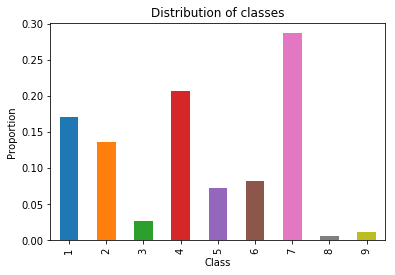

In [19]:
train_variants['Class'].value_counts(normalize=True).sort_index().plot.bar()
plt.title('Distribution of classes')
plt.xlabel('Class')
plt.ylabel('Proportion')

There are 4 fields in the `train_variants` dataset:
- **ID**: the id of the row used to link the mutation to the clinical evidence)
- **Gene**: the gene where this genetic mutation is located
- **Variation**: the [amino acid](https://en.wikipedia.org/wiki/Amino_acid) change for this mutation
- **Class**: 1-9 the class this genetic mutation has been classified on, which are also the target variables

There is no missing value and all column types are correctly defined.

There are 9 distinct classes and the labels are imbalanced and this probably need to be dealt with later. `Class 7` has the highest percentage among all the classes, while `Class 8` has the lowest percentage.

`train_text`

In [10]:
train_text.head(3)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


In [11]:
train_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [12]:
train_text.describe(include='O')

,TEXT
count,3316
unique,1920
top,The PTEN (phosphatase and tensin homolog) phos...
freq,53


In [13]:
train_text['TEXT'][0]

"Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK1

There are 2 fields in the `train_text` dataset:
- **ID**: the id of the row used to link the mutation to the clinical evidence)
- **TEXT**: the clinical evidence used to classify the genetic mutation

The text data contains huge amount of information,and it contains some strange symbols such as �. it is important that we remove these prior to the analysis.

### Text Data Cleaning

In [127]:
def text_preprocess(text):
    # Remove int values from text data as that might not be imp
    if type(text) is not int:
        # replace anything within parenthese with space
        text = re.sub('\(([^\)]+)\)',' ',str(text))
        
        # replacing all special char with space
        text = re.sub('[^a-zA-Z0-9\n]', ' ', str(text))
        
        # bring whole text to same lower-case scale.
        text = text.lower()
        
        # remove 'fig. '
        text = re.sub('fig\s+\d','',str(text))
        
        #remove 'figure'
        text = re.sub('figure','',str(text))
        
        #remove 'et al'
        text = re.sub('et al','',str(text))
        
        # replacing multiple spaces with space
        text = re.sub('\s+',' ', str(text))
        
    return text

In [128]:
train_text['TEXT'] = train_text['TEXT'].apply(text_preprocess)

In [124]:
#import stopwords from nltk
stop_words = list(set(stopwords.words('english')))

In [125]:
#remove stopwords from TEXT
train_text['TEXT']=train_text['TEXT'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

In [129]:
train_text.head(3)

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...


Join `train_text` and `train_variants`

In [130]:
df = pd.merge(train_variants, train_text, on='ID',how='left')

In [131]:
df.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


Check missing values

In [94]:
df.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
TEXT         0
dtype: int64

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
TEXT         3321 non-null object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [96]:
df.describe(include='all')

,ID,Gene,Variation,Class,TEXT
count,3321.000000,3321,3321,3321.000000,3321
unique,NaN,264,2996,NaN,1921
top,NaN,BRCA1,Truncating Mutations,NaN,pten phosphatase tensin homolog phosphatase un...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


In [133]:
df.to_csv('data/train_cln.csv',index=False)

Word Cloud to show what are the frequent words in TEXT

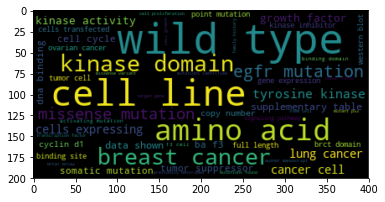

In [132]:
wordcloud = WordCloud(max_font_size=50, max_words=50).generate(' '.join(df['TEXT']))
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

From the word cloud we now can see the top frequent words appear in the TEXT data are: *wild type, kinase domain, cell line, amino acid and breast cancer* which are all relevant to the topic.

## Creating Training, Test and Validation Data

In [134]:
#save a copy
df_copy = df.copy()

In [135]:
df.head(3)

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...


In [136]:
y = df['Class']
X = df.copy()

In [138]:
#split into train, test, validation
X_t, X_test, y_t, y_test = train_test_split(X,y,stratify=y,test_size=0.2)
X_train,X_cv, y_train,y_cv = train_test_split(X_t,y_t, stratify=y_t, test_size=0.2)

In [139]:
#look at the shpae in each dataset
for df in [X_train, X_test, X_cv]:
    print (df.shape)

(2124, 5)
(665, 5)
(532, 5)


In [176]:
for df in [y_train,y_test,y_cv]:
    print (df.shape)

(2124,)
(665,)
(532,)


Look at the distribution of data in each dataset, this is to see do they share a similar distribution so that there is no bias in the data.

Text(0.5, 0, 'Class')

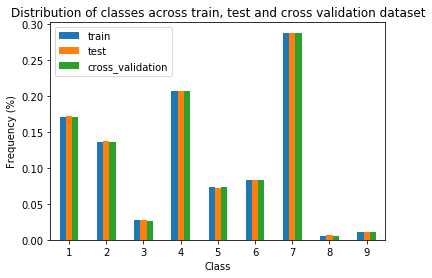

In [140]:
distribution_df = pd.concat([
    y_train.value_counts(normalize=True).sort_index(),
    y_test.value_counts(normalize=True).sort_index(),
    y_cv.value_counts(normalize=True).sort_index()
],axis=1)

distribution_df.columns=['train','test','cross_validation']

distribution_df.plot.bar()
plt.xticks(rotation=0)
plt.title('Distribution of classes across train, test and cross validation dataset')
plt.ylabel('Frequency (%)')
plt.xlabel('Class')

The bar plot above indicates that the distribution of data for each class is about the same across each dataset.

## Base model
The final evaluation matrix is multi-class log loss. A **random model** could be built to evaluate the log loss and our model should perform better than this random model and have a lower log loss. This is because for log-loss, generally a 'benchmark' model is need in order to provide a basis for us to evaluate our model.

In [141]:
test_data_len = len(y_test)
cv_data_len = len(y_cv)

#create output array exactly same size as the cross_validation dataset
base_cv_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_class_prob = np.random.rand(1,9)
    base_cv_y[i] = ((rand_class_prob/sum(sum(rand_class_prob)))[0])
    
#calculate log loss
print ('The log loss on cross validation data using base model: ',log_loss(y_cv,base_cv_y))

The log loss on cross validation data using base model:  2.5054352258251966


In [142]:
#similarly, create random model on test data
base_test_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_class_prob= np.random.rand(1,9)
    base_test_y[i] = ((rand_class_prob/sum(sum(rand_class_prob)))[0])

#calculate log loss
print ('The log loss on test data using base model: ',log_loss(y_test,base_test_y))

The log loss on test data using base model:  2.510199694751797


In [143]:
#get the index of max probability
base_pred_y = np.argmax(base_test_y,axis=1)
base_pred_y[:10]

array([8, 6, 8, 8, 1, 3, 3, 3, 3, 2], dtype=int64)

In [144]:
print ('Min class label: {}, max class label:{}'.format(base_pred_y.min(), base_pred_y.max()))

Min class label: 0, max class label:8


In [145]:
#because the classes range from 1 to 9, add 1 
base_pred_y +=1

Confusion matrix on base model test data

Text(0.5, 1.0, 'Confusion Matrix for Base Model')

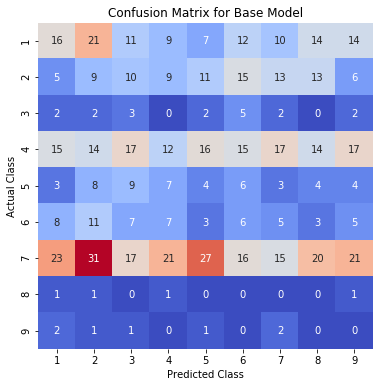

In [146]:
labels = list(range(1,10))
plt.figure(figsize=(6,6))
sns.heatmap(
            confusion_matrix(y_test.values, base_pred_y),
            cmap='coolwarm',xticklabels=labels,
            yticklabels=labels,cbar=False,annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix for Base Model')

**Precision**

Precision is also referred to as *postivie predictive value*. Which tells us out of all the predicted classes, what is the proportion that has been correctly classified compared to the true classes.

$precision=\frac{true \,positives}{true \,positives + false \,positives}$

Text(0.5, 1.0, 'Precision Matrix for Base Model')

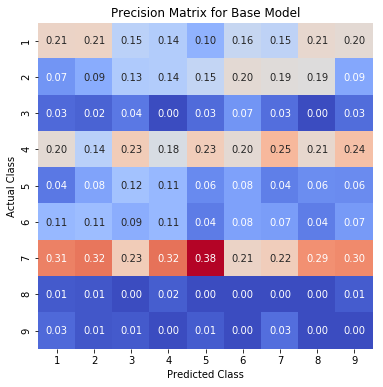

In [147]:
c = confusion_matrix(y_test.values, base_pred_y)
p = c/c.sum(axis=0)
plt.figure(figsize=(6,6))
sns.heatmap(
            p,cmap='coolwarm',xticklabels=labels,fmt=".2f",
            yticklabels=labels,cbar=False,annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Precision Matrix for Base Model')

**Recall**

Recall is also referred to as *true positive rate* or *sensitivity*, which tell us the model's predictive power or the proportion of the correctly predicted class out of all the actual classes.

$recall = \frac {true \,positives}{true \,positives + false \, negatives}$

Text(0.5, 1.0, 'Recall Matrix for Base Model')

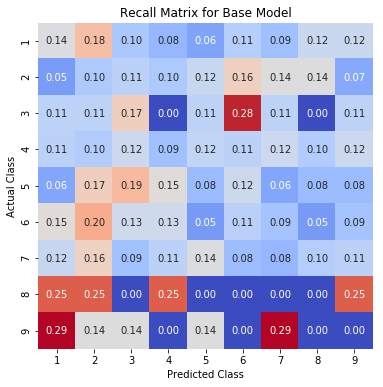

In [149]:
r = (((c.T)/(c.sum(axis=1))).T)
plt.figure(figsize=(6,6))
sns.heatmap(
            r,cmap='coolwarm',xticklabels=labels,fmt=".2f",
            yticklabels=labels,cbar=False,annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Recall Matrix for Base Model')

## Univariate Analysis - `Gene`

In [150]:
#number of unique genes
X_train['Gene'].nunique()

232

In [151]:
#frequency of top 10 unique genes
X_train['Gene'].value_counts().head(10)

BRCA1     164
TP53      105
EGFR       91
PTEN       85
BRCA2      76
KIT        65
BRAF       62
ERBB2      49
ALK        44
PIK3CA     35
Name: Gene, dtype: int64

It seems that BRCA1 is the gene mutation location occured most in our train dataset. BRCA2 also appears as the fifth most. According to [National Cancer Institute](https://www.cancer.gov/about-cancer/causes-prevention/genetics/brca-fact-sheet), *Harmful mutations in BRCA1 and BRCA2 increase the risk of several cancers in addition to breast and ovarian cancer.*. This seems make sense with the frequency count shown above. 

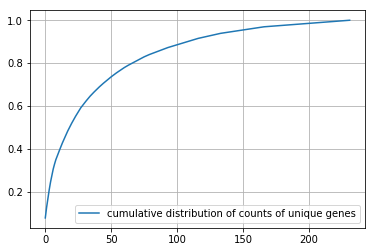

In [152]:
f = X_train['Gene'].value_counts(normalize=True)
c = np.cumsum(f)

plt.plot(c.values, label='cumulative distribution of counts of unique genes')
plt.grid()
plt.legend()
plt.show()

The cumulative distribution plot shows that around 60 unique genes are account for 80% of the observation.

We also need to convert categorical variable `Gene` to appropriate format (numeric) so that machine learning model understand the input.

First use One-hot encoding:

In [177]:
gene_cv = CountVectorizer()

#oh stands for one-hot encoding
train_gene_oh = gene_cv.fit_transform(X_train['Gene'])
test_gene_oh = gene_cv.transform(X_test['Gene'])
cv_gene_oh = gene_cv.transform(X_cv['Gene'])

train_gene_oh=normalize(train_gene_oh.toarray())
cv_gene_oh=normalize(cv_gene_oh.toarray())
test_gene_oh=normalize(test_gene_oh.toarray())

In [178]:
train_gene_oh.shape

(2124, 231)

In [179]:
train_gene_oh

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [155]:
cv_gene_oh.shape

(532, 250)

In [156]:
#col name after one-hot encoding
gene_cv.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gn

Next , we try use mean-imputation encoding, which also called response encoding. One problem that one-hot encoding may creat is that it generate more features. For example, in the training dataset we have 234 unique genes, for each gene we use one-hot encoding to assign a name to it. For example:

| Gene1| Gene2  | Gene3| ...|
| ---| ---| ---| ---|
| 1 | 0 | 0  | ...|
| 0 | 1 | 0  | ...|
| 0 | 0 | 1  | ...|
|...|...|... | ...|

Instead, we can use mean-imputation encoding to reduce the number of features, which means we are going to calcualte the probabily of classes each gene belongs to in the labeled data. In this case, we just create 9 new feautres instead of 234 which may help us prevent the high dimensionality problem. For exmaple:

| Gene | Class 1 | Class2 | Class 3 | ... | Class 9 |
|---|---|---|---|---|---|
| Gene1 | 0.3 | 0.7 | 0 |...| 0 |
| Gene2 | 0 | 0.2| 0| ...| 0.8|

We will also use laplace smoothing technique. This is a concept introduced for Naive Bayes, there is a good explanation [here](https://www.quora.com/What-is-Laplacian-smoothing-and-why-do-we-need-it-in-a-Naive-Bayes-classifier). This is because, there are so many English words and there might be chances that a word present in the test dataset may not appear in the train dataset.Using laplace smoothing would prevent that the model would think that a word never appear as 0. 

In [158]:
# get feature variation dictioanry
def feature_var_dict(a, f, df):
    """ Return a dictionary contains each gene variation
        a--> int (for laplace smoothing)
        f--> feature
        df --> dataframe"""
    value_count = df[f].value_counts()
    #initialize an empty dictionry
    f_var_dic = {}
    for i, d in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = df.loc[(df['Class']==k) & (df[f]==i)]
            vec.append((cls_cnt.shape[0] + a*10)/(d+ 90*a))
    
        #add gene/variation to dict 
        f_var_dic[i] = vec
    return f_var_dic    

In [164]:
# get variationfeature
def var_features(a,f,df):
    """ Return a list of features variation
        a --> int (for laplace smoothing)
        f --> feature
        df --> dataframe"""
    var_dic = feature_var_dict(a,f,df)
    value_count = df[f].value_counts()
    
    var_feat =[]
    for i,row in df.iterrows():
        if row[f] in dict(value_count).keys():
            var_feat.append(var_dic[row[f]])
        else:
            var_feat.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return np.array(var_feat)

In [165]:
#a = 1 for laplace smoothing
a = 1
#rc stands for response coding
train_gene_rc = var_features(a,'Gene',X_train)
test_gene_rc = var_features(a,'Gene',X_test)
cv_gene_rc = var_features(a,'Gene',X_cv)

First attempt with SGD Classifier. SGD stands for Stochastic Gradient Descent, which considers only 1 random point while changing wiehgts unlike gradient descent which considers the whole training data. Thus, SGD is much faster than gradient descent when working on larger data sets. See more [here](https://towardsdatascience.com/how-to-make-sgd-classifier-perform-as-well-as-logistic-regression-using-parfit-cc10bca2d3c4)

We will also use Calibrated Classification model to predict the probability of an observation belonging to each possible class instead of directly predicting classes. In this way, it is easier for us to calcualte log loss since the equation needs probablity as input. See more info [here](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/)

In [183]:
def sgd_hp_search(train,y_train,test,y_test):
    """ print out log loss for each alpha
        train --> training dataset
        y_true
        test --> test dataset"""
    #hyperparameter for SGD clasifier
    alpha = [10**x for x in range(-5,1)]
    cv_log_error = []
    for i in alpha:
        clf = SGDClassifier(alpha = i, penalty='l2', loss='log', random_state=101)
        clf.fit(train,y_train.values)
        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(train,y_train.values)
        y_pred = sig_clf.predict_proba(test)
        cv_log_error.append(log_loss(y_test.values, y_pred, labels=clf.classes_))
        print ('alpha = ',i,'log loss: ',log_loss(y_test.values, y_pred, labels=clf.classes_))
    
    fig, ax = plt.subplots()
    ax.plot(alpha, cv_log_error,c='g')
    for i, txt in enumerate(np.round(cv_log_error,3)):
        ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha (i)")
    plt.ylabel("Error measure: Log Loss")
    plt.show()

Use ont-hot encoded `Gene` features

alpha =  1e-05 log loss:  1.2479818878343505
alpha =  0.0001 log loss:  1.1819433863241755
alpha =  0.001 log loss:  1.2094786528965005
alpha =  0.01 log loss:  1.3245972427107602
alpha =  0.1 log loss:  1.3752455004960373
alpha =  1 log loss:  1.3910500296038253


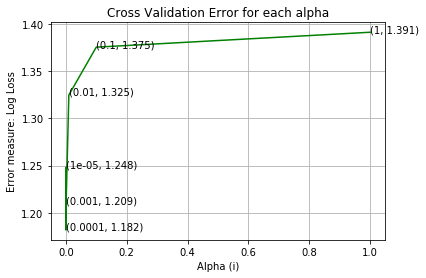

In [184]:
#hyperparameter for SGD clasifier
sgd_hp_search(train_gene_oh,y_train,cv_gene_oh, y_cv)

In [185]:
best_alpha = 0.0001

In [186]:
#use the best alpha to compute log loss  for train,cross_validation, as well as test dataset
clf = SGDClassifier(alpha=best_alpha, penalty='l2',loss='log', random_state=101)
clf.fit(train_gene_oh, y_train.values)
sig_clf=CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_gene_oh, y_train.values)

print ('Train log loss: ',
      log_loss(y_train, sig_clf.predict_proba(train_gene_oh), labels=clf.classes_))
print ('Cross validation log loss:',
      log_loss(y_cv, sig_clf.predict_proba(cv_gene_oh), labels=clf.classes_))
print ('Test log loss: ',
      log_loss(y_test, sig_clf.predict_proba(test_gene_oh), labels=clf.classes_))

Train log loss:  1.048158953481948
Cross validation log loss: 1.1819433863241755
Test log loss:  1.2274062189593744


Use resposne-encoded `Gene` features

alpha =  1e-05 log loss:  1.3769362080046137
alpha =  0.0001 log loss:  1.4003588789830954
alpha =  0.001 log loss:  1.477347621057973
alpha =  0.01 log loss:  1.5135225605267046
alpha =  0.1 log loss:  1.523267220499083
alpha =  1 log loss:  1.5246655851445703


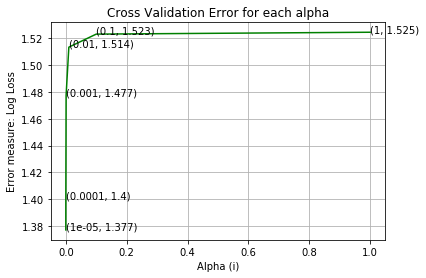

In [187]:
sgd_hp_search(train_gene_rc,y_train, cv_gene_rc, y_cv)

Interestingly, it seems that response-encoded features actually have a bigger log-loss.

Check the number of values overlapping between train, test or between train and corss validation.

In [190]:
def coverage(train,test,cv,f):
    """ print out coverage / proportion of values overlapping
        bewteen train , test and train, cross validation set
        train --> train dataset
        test --> test dataset
        cv --> cross validation dataset
        f --> feature (str)"""
    test_coverage = test[test[f].isin(list(set(train[f])))].shape[0]
    cv_coverage = cv[cv[f].isin(list(set(train[f])))].shape[0]
    print ('In test data {} out of {} ({}) overlap with training dataset.'.format(
        test_coverage, len(test), (test_coverage/len(test))))
    print ('In cross validation data {} out of {} ({}) overlap with training dataset.'.format(
        cv_coverage, len(cv), (cv_coverage/len(cv))))

In [191]:
coverage(X_train, X_test, X_cv, 'Gene')

In test data 649 out of 665 (0.9759398496240601) overlap with training dataset.
In cross validation data 512 out of 532 (0.9624060150375939) overlap with training dataset.


Based on the result, it showed that `Gene` feature reduced the log loss from our base model and it is likely to be an important feature for model bulding. The proportion of overlapping of `Gene` feautre across each data is quite high which indicates a good stability of this feature and it is going to be used in the final model. 

Next,let's look at the sceond feature `Variation` 

## Univariate Analysis - `Variation`

In [193]:
#number of unique variation
X_train['Variation'].nunique()

1920

In [194]:
#top 10 variations that occured most
X_train['Variation'].value_counts(normalize=True).head(10)

Truncating Mutations    0.030132
Amplification           0.022128
Deletion                0.021657
Fusions                 0.011770
E17K                    0.001412
Q61R                    0.001412
Overexpression          0.000942
G35R                    0.000942
P34R                    0.000942
G12V                    0.000942
Name: Variation, dtype: float64

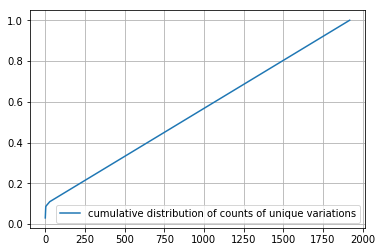

In [195]:
f = X_train['Variation'].value_counts(normalize=True)
c = np.cumsum(f)

plt.plot(c.values, label='cumulative distribution of counts of unique variations')
plt.grid()
plt.legend()
plt.show()

One hot encoding

In [196]:
variation_cv = CountVectorizer()
#oh stands for one-hot encoding
train_variation_oh = variation_cv.fit_transform(X_train['Variation'])
test_variation_oh = variation_cv.transform(X_test['Variation'])
cv_variation_oh = variation_cv.transform(X_cv['Variation'])

train_variation_oh=normalize(train_variation_oh.toarray())
test_variation_oh=normalize(test_variation_oh.toarray())
cv_variation_oh=normalize(cv_variation_oh.toarray())

Response encoding

In [198]:
#a = 1 for laplace smoothing
a = 1
#rc stands for response coding
train_variation_rc = var_features(a,'Variation',X_train)
test_variation_rc = var_features(a,'Variation',X_test)
cv_variation_rc = var_features(a,'Variation',X_cv)

alpha =  1e-05 log loss:  1.7225141715642303
alpha =  0.0001 log loss:  1.71645093585168
alpha =  0.001 log loss:  1.720089326083955
alpha =  0.01 log loss:  1.7266753871431013
alpha =  0.1 log loss:  1.7293527514332443
alpha =  1 log loss:  1.7245432100004483


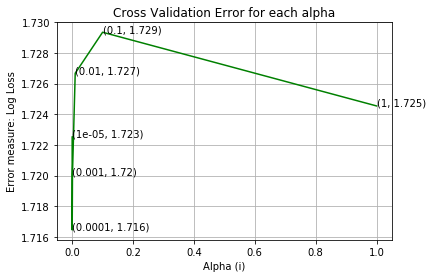

In [200]:
sgd_hp_search(train_variation_oh,y_train,cv_variation_oh,y_cv)

alpha =  1e-05 log loss:  0.5259196433335568
alpha =  0.0001 log loss:  0.6206865280257138
alpha =  0.001 log loss:  0.8640776788166991
alpha =  0.01 log loss:  0.9503805434697337
alpha =  0.1 log loss:  0.98841649530552
alpha =  1 log loss:  0.9418213110208998


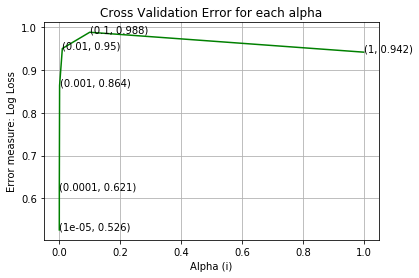

In [201]:
sgd_hp_search(train_variation_rc,y_train, cv_variation_rc,y_cv)

In [202]:
coverage(X_train,X_test,X_cv,'Variation')

In test data 58 out of 665 (0.08721804511278196) overlap with training dataset.
In cross validation data 55 out of 532 (0.10338345864661654) overlap with training dataset.


Although `Variation` feature gives a pretty good log loss when using response encoding, the proportion this feautres appear across the datasets are very little, which means that most of the Variation will not repeat themselves, which will increase for the model to learn since it has never seen the feature before. 

For now, `Variation` may not be good feature to be considered in the final model.

## Univariate Analysis - `TEXT`
The `TEXT` feature is probably the most important feature as this is the data that medical doctor will look at and determine the genetic mutation.

In [203]:
#create count for each word appear in the 'TEXT' column
def extract_word_dict (df):
    """ Return a dictionary containing count for each word appear in 
        the TEXT column
        df --> dataframe"""
    some_dict = defaultdict(int)
    for i, row in df.iterrows():
        for word in row['TEXT'].split():
            some_dict[word] +=1
    return some_dict

In [206]:
#response encoding for TEXT feature
def text_rc (df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

one-hot encoding

In [236]:
text_cv = CountVectorizer(min_df=3)
train_text_oh = text_cv.fit_transform(X_train['TEXT'])
test_text_oh = text_cv.transform(X_test['TEXT'])
cv_text_oh = text_cv.transform(X_cv['TEXT'])

train_text_oh = normalize(train_text_oh.toarray())
test_text_oh = normalize(test_text_oh.toarray())
cv_text_oh = normalize(cv_text_oh.toarray())

response encoding

In [239]:
total_dict = extract_word_dict(X_t)

In [240]:
train_text_rc = text_re(X_train)
test_text_rc = text_re(X_test)
cv_text_rc = text_re(X_cv)

In [241]:
#conver row values so that the sum is 1
train_text_rc = (train_text_rc.T/train_text_rc.sum(axis=1)).T

train_text_rc[0].sum()

1.0

In [242]:
#convert the rest
test_text_rc = (test_text_rc.T/test_text_rc.sum(axis=1)).T
cv_text_rc = (cv_text_rc.T/cv_text_rc.sum(axis=1)).T

alpha =  1e-05 log loss:  1.0643609172493456
alpha =  0.0001 log loss:  1.0274649412905041
alpha =  0.001 log loss:  1.1231758488499446
alpha =  0.01 log loss:  1.247798113269163
alpha =  0.1 log loss:  1.3123598218212404
alpha =  1 log loss:  1.4046598900632632


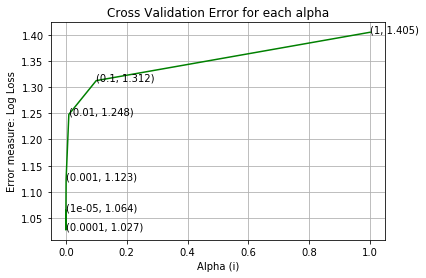

In [243]:
sgd_hp_search(train_text_oh,y_train,cv_text_oh,y_cv)

alpha =  1e-05 log loss:  1.1835853986580591
alpha =  0.0001 log loss:  1.2097143661210834
alpha =  0.001 log loss:  1.354934933797106
alpha =  0.01 log loss:  1.4049889243652076
alpha =  0.1 log loss:  1.418820928666806
alpha =  1 log loss:  1.4303185201443653


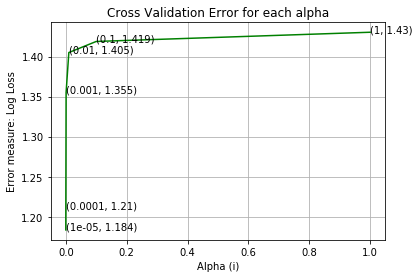

In [244]:
sgd_hp_search(train_text_rc, y_train, cv_text_rc, y_cv)

# Model Building

In [247]:
def log_loss_value(x_train,y_train,x_test,y_test,clf):
    """ return log loss
        clf --> ML model"""
    clf.fit(x_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(x_train, y_train)
    sig_clf_probs = sig_clf.predict_proba(x_test)
    return log_loss(y_test, sig_clf_probs)

In [246]:
def plot_confusion_matrix(y_true, y_pred):
    """ Plot confusion matrix, precision matrix and recall matrix"""
    c = confusion_matrix(y_true.values, y_pred)
    p = c/c.sum(axis=0)
    r = (((c.T)/(c.sum(axis=1))).T)
    
    labels = list(range(1,10))
    plt.figure(figsize=(6,6))
    sns.heatmap(
                c,
                cmap='coolwarm',xticklabels=labels,
                yticklabels=labels,cbar=False,annot=True)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Confusion Matrix')
    plt.show()
    
    plt.figure(figsize=(6,6))
    sns.heatmap(
                p,cmap='coolwarm',xticklabels=labels,fmt=".2f",
                yticklabels=labels,cbar=False,annot=True)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Precision Matrix')
    plt.show()
    
    plt.figure(figsize=(6,6))
    sns.heatmap(
                r,cmap='coolwarm',xticklabels=labels,fmt=".2f",
                yticklabels=labels,cbar=False,annot=True)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Recall Matrix')

In [249]:
def predict_plot_confusion_matrix (x_train,y_train, x_test,y_test,clf):
    clf.fit(x_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(x_train,y_train)
    y_pred = sig_clf.predict(x_test)
    sig_clf_probs = sig_clf.predict_proba(x_test)
    
    print ('Log loss: ', log_loss(y_test,sig_clf_probs))
    print ('NUmber of misscalssified points: ',np.count_nonzero((y_pred - y_test))/y_test.shape[0])
    plot_confusion_matrix(y_test,y_pred)
    

## Combining all 3 features

In [255]:
train_gene_var_oh = np.concatenate((train_gene_oh, train_variation_oh),axis=1)
test_gene_var_oh = np.concatenate((test_gene_oh,test_variation_oh),axis=1)
cv_gene_var_oh = np.concatenate((cv_gene_oh, cv_variation_oh),axis=1)

In [257]:
print (train_gene_oh.shape, train_variation_oh.shape)

(2124, 231) (2124, 1957)


In [256]:
train_gene_var_oh.shape

(2124, 2188)

In [258]:
x_train_oh = np.concatenate((train_gene_var_oh, train_text_oh), axis=1)

In [260]:
x_test_oh = np.concatenate((test_gene_var_oh, test_text_oh),axis=1)
x_cv_oh = np.concatenate((cv_gene_var_oh, cv_text_oh), axis=1)

In [261]:
print (x_train_oh.shape, x_test_oh.shape, x_cv_oh.shape)

(2124, 54689) (665, 54689) (532, 54689)


In [262]:
train_gene_var_rc = np.concatenate((train_gene_rc, train_variation_rc),axis=1)
x_train_rc = np.concatenate((train_gene_var_rc, train_text_rc),axis=1)

In [263]:
test_gene_var_rc = np.concatenate((test_gene_rc, test_variation_rc),axis=1)
x_test_rc = np.concatenate((test_gene_var_rc, test_text_rc),axis=1)

In [264]:
cv_gene_var_rc = np.concatenate((cv_gene_rc, cv_variation_rc),axis=1)
x_cv_rc = np.concatenate((cv_gene_var_rc, cv_text_rc), axis=1)

In [265]:
print (x_train_rc.shape, x_test_rc.shape, x_cv_rc.shape)

(2124, 27) (665, 27) (532, 27)


## Naive Bayes

alpha =  1e-05 log loss:  1.1488533672632466
alpha =  0.0001 log loss:  1.1487784084404171
alpha =  0.001 log loss:  1.146147905354948
alpha =  0.01 log loss:  1.1638105378919217
alpha =  0.1 log loss:  1.2347263823507095
alpha =  1 log loss:  1.3472104312865263
alpha =  10 log loss:  1.3223885047584396
alpha =  100 log loss:  1.317509768705449
alpha =  1000 log loss:  1.3268771166282503


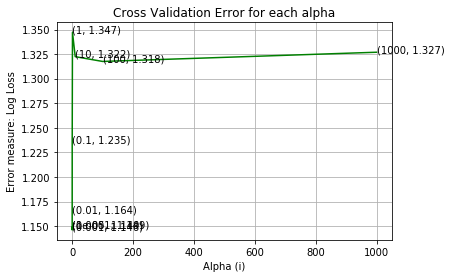

In [284]:
alpha = [10**x for x in range(-5,4)]
cv_log_error = []
for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(x_train_oh, y_train.values)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(x_train_oh, y_train.values)
    y_pred = sig_clf.predict_proba(x_cv_oh)
    cv_log_error.append(log_loss(y_cv.values, y_pred, labels=clf.classes_))
    print ('alpha = ',i,'log loss: ',log_loss(y_cv.values, y_pred, labels=clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha (i)")
plt.ylabel("Error measure: Log Loss")
plt.show()

Log loss:  1.146147905354948
NUmber of misscalssified points:  0.3458646616541353


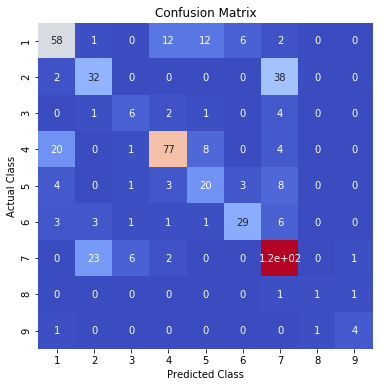

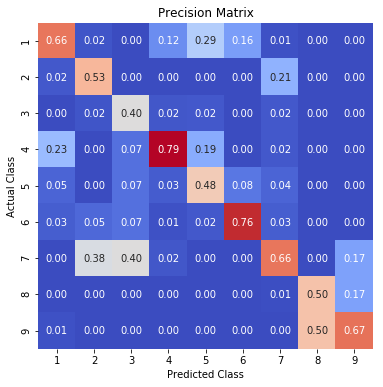

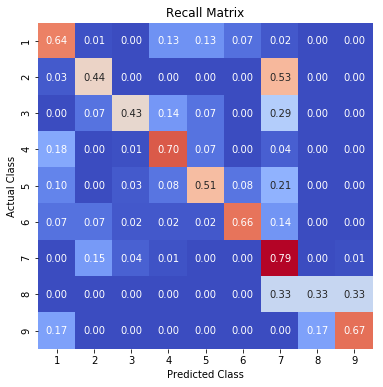

In [285]:
#alpha = 0.001 gives the smallest log loss
clf = MultinomialNB(alpha=0.001)

predict_plot_confusion_matrix(x_train_oh,y_train, x_cv_oh, y_cv,clf)

Log loss:  1.1372106919118743
NUmber of misscalssified points:  0.3458646616541353


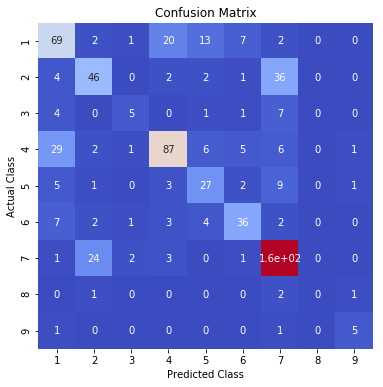

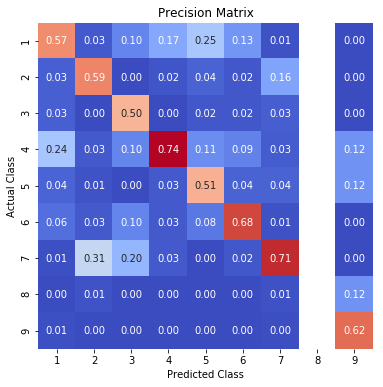

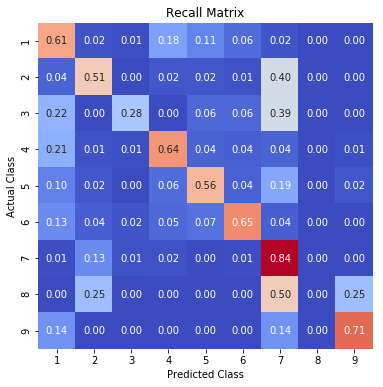

In [286]:
#alpha = 0.001 gives the smallest log loss
clf = MultinomialNB(alpha=0.001)

predict_plot_confusion_matrix(x_train_oh,y_train, x_test_oh, y_test,clf)

alpha =  1e-05 log loss:  1.3440282648034825
alpha =  0.0001 log loss:  1.3440288479668974
alpha =  0.001 log loss:  1.3440347425549806
alpha =  0.01 log loss:  1.3441013830305244
alpha =  0.1 log loss:  1.3451078811670723
alpha =  1 log loss:  1.361402889621286
alpha =  10 log loss:  1.379085062266854
alpha =  100 log loss:  1.3706110299974215
alpha =  1000 log loss:  1.3683278112775812


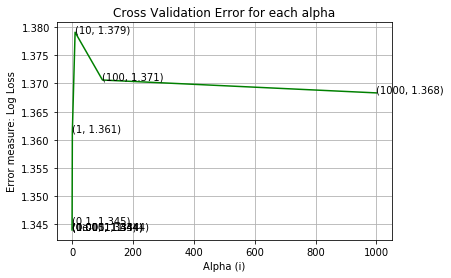

In [291]:
#resposne encoding
alpha = [10**x for x in range(-5,4)]
cv_log_error = []
for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(x_train_rc, y_train.values)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(x_train_rc, y_train.values)
    y_pred = sig_clf.predict_proba(x_cv_rc)
    cv_log_error.append(log_loss(y_cv.values, y_pred, labels=clf.classes_))
    print ('alpha = ',i,'log loss: ',log_loss(y_cv.values, y_pred, labels=clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha (i)")
plt.ylabel("Error measure: Log Loss")
plt.show()

Log loss:  1.3125054020991251
NUmber of misscalssified points:  0.43759398496240604


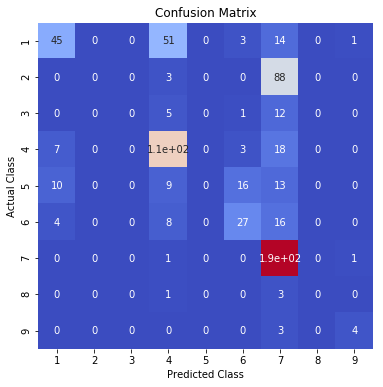

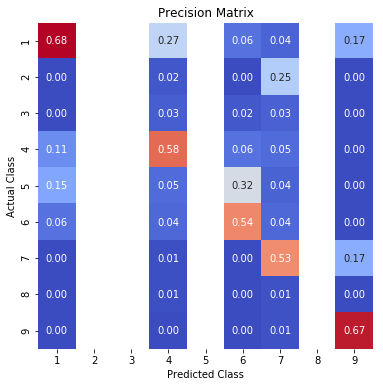

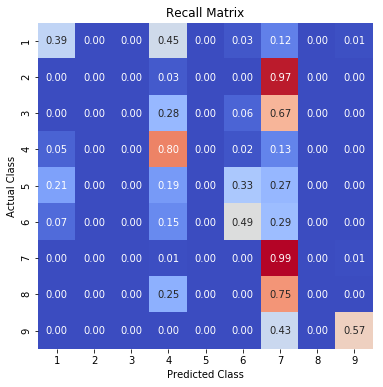

In [292]:
#alpha = 0.0001 gives the smallest log loss
clf = MultinomialNB(alpha=0.0001)

predict_plot_confusion_matrix(x_train_rc,y_train, x_test_rc, y_test,clf)

## KNN

In [ ]:
alpha = [2**x for x in range(1,8)]
cv_log_error = []
for i in alpha:
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(x_train_oh, y_train.values)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(x_train_oh, y_train.values)
    y_pred = sig_clf.predict_proba(x_cv_oh)
    cv_log_error.append(log_loss(y_cv.values, y_pred, labels=clf.classes_))
    print ('alpha = ',i,'log loss: ',log_loss(y_cv.values, y_pred, labels=clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha (i)")
plt.ylabel("Error measure: Log Loss")
plt.show()

Log loss:  0.8475414582107417
NUmber of misscalssified points:  0.26165413533834586


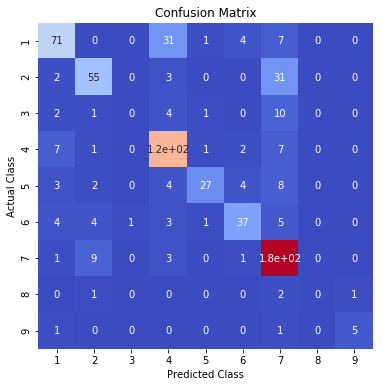

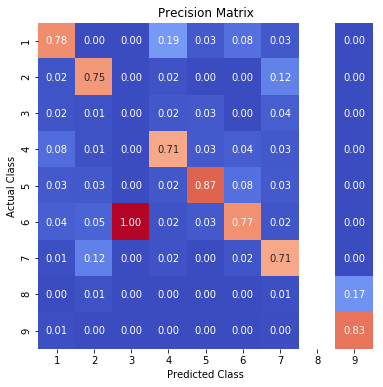

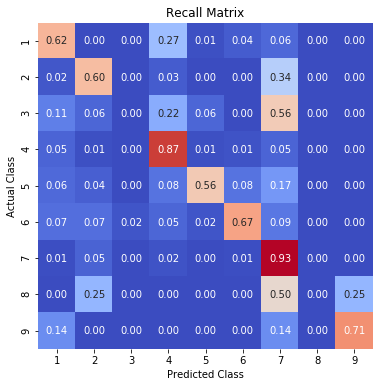

In [301]:
#when alpha = 4 is the best
#KNN is very slow
clf = KNeighborsClassifier(n_neighbors=4)

predict_plot_confusion_matrix(x_train_rc,y_train, x_test_rc, y_test,clf)

KNN actually works quite good.

## SGDClassifier (Logistic Regression)

alpha =  1e-06 log loss:  1.042089546622566
alpha =  1e-05 log loss:  1.0320884766594192
alpha =  0.0001 log loss:  0.9777769513219479
alpha =  0.001 log loss:  1.0222225186058158
alpha =  0.01 log loss:  1.148538587106928
alpha =  0.1 log loss:  1.2080010546559123
alpha =  1 log loss:  1.260382343710273
alpha =  10 log loss:  1.515067443714483
alpha =  100 log loss:  1.6045233271983008


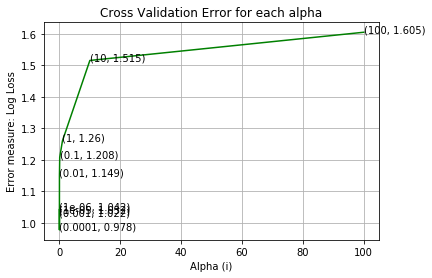

In [302]:
alpha = [10**x for x in range(-6,3)]
cv_log_error = []
for i in alpha:
    clf = SGDClassifier(class_weight='balanced',alpha=i, penalty='l2',loss='log')
    clf.fit(x_train_oh, y_train.values)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(x_train_oh, y_train.values)
    y_pred = sig_clf.predict_proba(x_cv_oh)
    cv_log_error.append(log_loss(y_cv.values, y_pred, labels=clf.classes_))
    print ('alpha = ',i,'log loss: ',log_loss(y_cv.values, y_pred, labels=clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha (i)")
plt.ylabel("Error measure: Log Loss")
plt.show()

Log loss:  0.9878498124340332
NUmber of misscalssified points:  0.3157894736842105


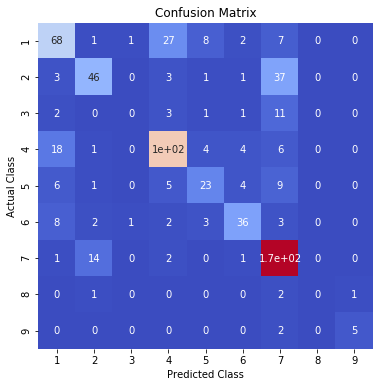

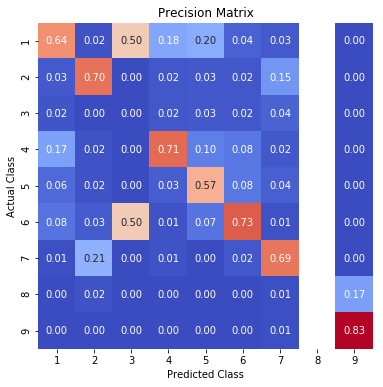

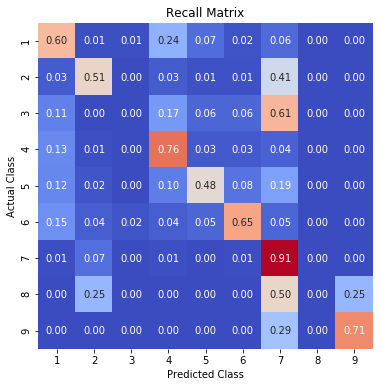

In [304]:
#when alpha = 0.0001 is the best
#KNN is very slow
clf = SGDClassifier(class_weight='balanced',alpha=0.0001, penalty='l2',loss='log')

predict_plot_confusion_matrix(x_train_oh,y_train, x_test_oh, y_test,clf)

SGD (logistic regression) performs quite good as well. Now let's use random forest.

## Random Forest Classifier